In [44]:
import torch
import torch.nn as nn
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [45]:
num_epochs = 500
batch_size = 1
learning_rate = 0.001

input_size = 222
sequence_length = 4
hidden_size = 128
num_layers = 2

In [46]:
initialize=True

In [47]:
df = pd.read_csv('../data/united_data.csv', index_col=0).fillna(0)
y = df['Corn_Yield']
X = df.drop(columns=['Corn_Yield'], axis=1)

In [48]:
y = pd.DataFrame(y)
def convert_corn_yield(row):
    idx = row.name
    year = int(idx[:4])
    row['Corn_Yield'] = row['Corn_Yield'] + (1950-year)*1.96966271
    return row
    

In [49]:
y = y.apply(convert_corn_yield, axis=1)
y = y['Corn_Yield']

In [50]:
correct = y[y>0].index

In [51]:
y = y[correct]
X = X.loc[correct]

In [52]:
class MyDataset(Dataset):
 
  def __init__(self,X,y):
    self.x_train=torch.tensor(X,dtype=torch.float32)
    self.y_train=torch.tensor(y,dtype=torch.float32)
 
  def __len__(self):
    return len(self.y_train)
   
  def __getitem__(self,idx):
    return self.x_train[idx],self.y_train[idx]

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=1)

In [54]:
train_data=MyDataset(X_train.to_numpy(), y_train.to_numpy())
train_loader=DataLoader(train_data,batch_size=batch_size,shuffle=False)

test_data=MyDataset(X_test.to_numpy(), y_test.to_numpy())
train_loader=DataLoader(test_data,batch_size=batch_size,shuffle=False)

In [55]:
X_train = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
X_test = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
y_train = torch.tensor(y_train.to_numpy(), dtype=torch.float32)
y_test = torch.tensor(y_test.to_numpy(), dtype=torch.float32)


In [56]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
    def forward(self, x):
        if initialize:
            h0 = torch.zeros(num_layers, x.size(0), hidden_size)
            c0 = torch.zeros(num_layers, x.size(0), hidden_size)
            x, _ = self.lstm(x,(h0,c0))
        else:
            x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.linear(x)
        return x

In [57]:
model = LSTM(input_size, hidden_size, num_layers)
weather_test = X_test.reshape(-1, sequence_length, input_size)
weather_train = X_train.reshape(-1, sequence_length, input_size)
print(weather_test.shape)
print(weather_train.shape)

torch.Size([313, 4, 222])
torch.Size([939, 4, 222])


## Train the model

In [34]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  
n_total_steps = len(train_loader)
train_losses = []
test_losses = []
min_test_loss = 9999999
for epoch in range(num_epochs):
    for i, (weather, labels) in enumerate(train_loader):  
        weather = weather.reshape(-1, sequence_length, input_size)
        
        # Forward pass
        outputs = model(weather)
        loss = criterion(outputs.reshape(-1), labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
#         if (i+1) % 100 == 0:
#             print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
    if (epoch + 1) % 1 == 0:
        with torch.no_grad():
            outputs = model(weather_train)
            loss_train = criterion(outputs.reshape(-1), y_train)
            outputs = model(weather_test)
            loss_test = criterion(outputs.reshape(-1), y_test)
            train_losses.append(loss_train)
            test_losses.append(loss_test)
            if loss_test < min_test_loss:
                min_test_loss = loss_test
                torch.save(model.state_dict(), "lstm-adjusted-corrected-gt0-500")
            print("Epoch: ", epoch + 1, " Train loss: ", loss_train.item(), "Test loss:", loss_test.item())

Epoch:  1  Train loss:  460.0664367675781 Test loss: 466.41558837890625
Epoch:  2  Train loss:  445.4092712402344 Test loss: 452.8222961425781
Epoch:  3  Train loss:  363.2572021484375 Test loss: 355.513916015625
Epoch:  4  Train loss:  323.6658630371094 Test loss: 317.20697021484375
Epoch:  5  Train loss:  325.7540588378906 Test loss: 327.2501525878906
Epoch:  6  Train loss:  300.8848571777344 Test loss: 282.37701416015625
Epoch:  7  Train loss:  286.7074890136719 Test loss: 263.114501953125
Epoch:  8  Train loss:  277.4444885253906 Test loss: 249.7525177001953
Epoch:  9  Train loss:  274.568115234375 Test loss: 232.5042724609375
Epoch:  10  Train loss:  268.6725769042969 Test loss: 225.31753540039062
Epoch:  11  Train loss:  277.3699035644531 Test loss: 208.15118408203125
Epoch:  12  Train loss:  282.23779296875 Test loss: 207.10304260253906
Epoch:  13  Train loss:  267.8537902832031 Test loss: 229.50709533691406
Epoch:  14  Train loss:  274.66278076171875 Test loss: 194.430313110351

Epoch:  114  Train loss:  231.64877319335938 Test loss: 68.40169525146484
Epoch:  115  Train loss:  253.2326202392578 Test loss: 70.18984985351562
Epoch:  116  Train loss:  219.5470733642578 Test loss: 64.83866882324219
Epoch:  117  Train loss:  241.92083740234375 Test loss: 63.7974739074707
Epoch:  118  Train loss:  250.32786560058594 Test loss: 59.91258239746094
Epoch:  119  Train loss:  229.31089782714844 Test loss: 61.182884216308594
Epoch:  120  Train loss:  231.4961700439453 Test loss: 55.94564437866211
Epoch:  121  Train loss:  241.93092346191406 Test loss: 50.71474075317383
Epoch:  122  Train loss:  237.818115234375 Test loss: 55.95485305786133
Epoch:  123  Train loss:  238.0182647705078 Test loss: 65.50145721435547
Epoch:  124  Train loss:  246.82643127441406 Test loss: 57.69804382324219
Epoch:  125  Train loss:  243.63259887695312 Test loss: 67.03091430664062
Epoch:  126  Train loss:  248.3116912841797 Test loss: 66.60359954833984
Epoch:  127  Train loss:  231.3076934814453 T

Epoch:  226  Train loss:  242.04322814941406 Test loss: 42.00602340698242
Epoch:  227  Train loss:  243.70484924316406 Test loss: 42.059783935546875
Epoch:  228  Train loss:  235.46334838867188 Test loss: 52.56166458129883
Epoch:  229  Train loss:  264.3491516113281 Test loss: 70.06812286376953
Epoch:  230  Train loss:  270.9444885253906 Test loss: 58.187076568603516
Epoch:  231  Train loss:  257.1357116699219 Test loss: 48.429786682128906
Epoch:  232  Train loss:  259.5238037109375 Test loss: 70.0380859375
Epoch:  233  Train loss:  245.0882110595703 Test loss: 45.26259231567383
Epoch:  234  Train loss:  263.34033203125 Test loss: 43.98318099975586
Epoch:  235  Train loss:  270.98724365234375 Test loss: 46.98246765136719
Epoch:  236  Train loss:  269.40228271484375 Test loss: 47.774269104003906
Epoch:  237  Train loss:  268.4056701660156 Test loss: 46.79411315917969
Epoch:  238  Train loss:  236.97964477539062 Test loss: 43.08766555786133
Epoch:  239  Train loss:  250.5872039794922 Tes

Epoch:  338  Train loss:  289.7066955566406 Test loss: 49.93171691894531
Epoch:  339  Train loss:  278.6651916503906 Test loss: 40.17976379394531
Epoch:  340  Train loss:  273.29168701171875 Test loss: 49.80080795288086
Epoch:  341  Train loss:  262.3515930175781 Test loss: 33.236141204833984
Epoch:  342  Train loss:  269.9508361816406 Test loss: 30.63929557800293
Epoch:  343  Train loss:  246.0091552734375 Test loss: 41.09569549560547
Epoch:  344  Train loss:  260.1903381347656 Test loss: 33.40671157836914
Epoch:  345  Train loss:  249.9426727294922 Test loss: 34.477806091308594
Epoch:  346  Train loss:  264.648681640625 Test loss: 57.960758209228516
Epoch:  347  Train loss:  244.7366180419922 Test loss: 46.089481353759766
Epoch:  348  Train loss:  257.51153564453125 Test loss: 34.00982666015625
Epoch:  349  Train loss:  268.4511413574219 Test loss: 27.459461212158203
Epoch:  350  Train loss:  255.99803161621094 Test loss: 23.101438522338867
Epoch:  351  Train loss:  259.9775390625 Te

Epoch:  450  Train loss:  291.1861572265625 Test loss: 32.409210205078125
Epoch:  451  Train loss:  279.333984375 Test loss: 28.92400360107422
Epoch:  452  Train loss:  259.3956604003906 Test loss: 34.41215133666992
Epoch:  453  Train loss:  284.0936584472656 Test loss: 43.2435188293457
Epoch:  454  Train loss:  285.5464782714844 Test loss: 29.591596603393555
Epoch:  455  Train loss:  263.25189208984375 Test loss: 42.13238525390625
Epoch:  456  Train loss:  308.85772705078125 Test loss: 61.84892272949219
Epoch:  457  Train loss:  292.1643981933594 Test loss: 42.374881744384766
Epoch:  458  Train loss:  291.4228210449219 Test loss: 40.81118392944336
Epoch:  459  Train loss:  289.6463623046875 Test loss: 34.46232223510742
Epoch:  460  Train loss:  266.0305480957031 Test loss: 43.41252899169922
Epoch:  461  Train loss:  272.3253173828125 Test loss: 32.538543701171875
Epoch:  462  Train loss:  279.845703125 Test loss: 35.354331970214844
Epoch:  463  Train loss:  260.4071044921875 Test loss

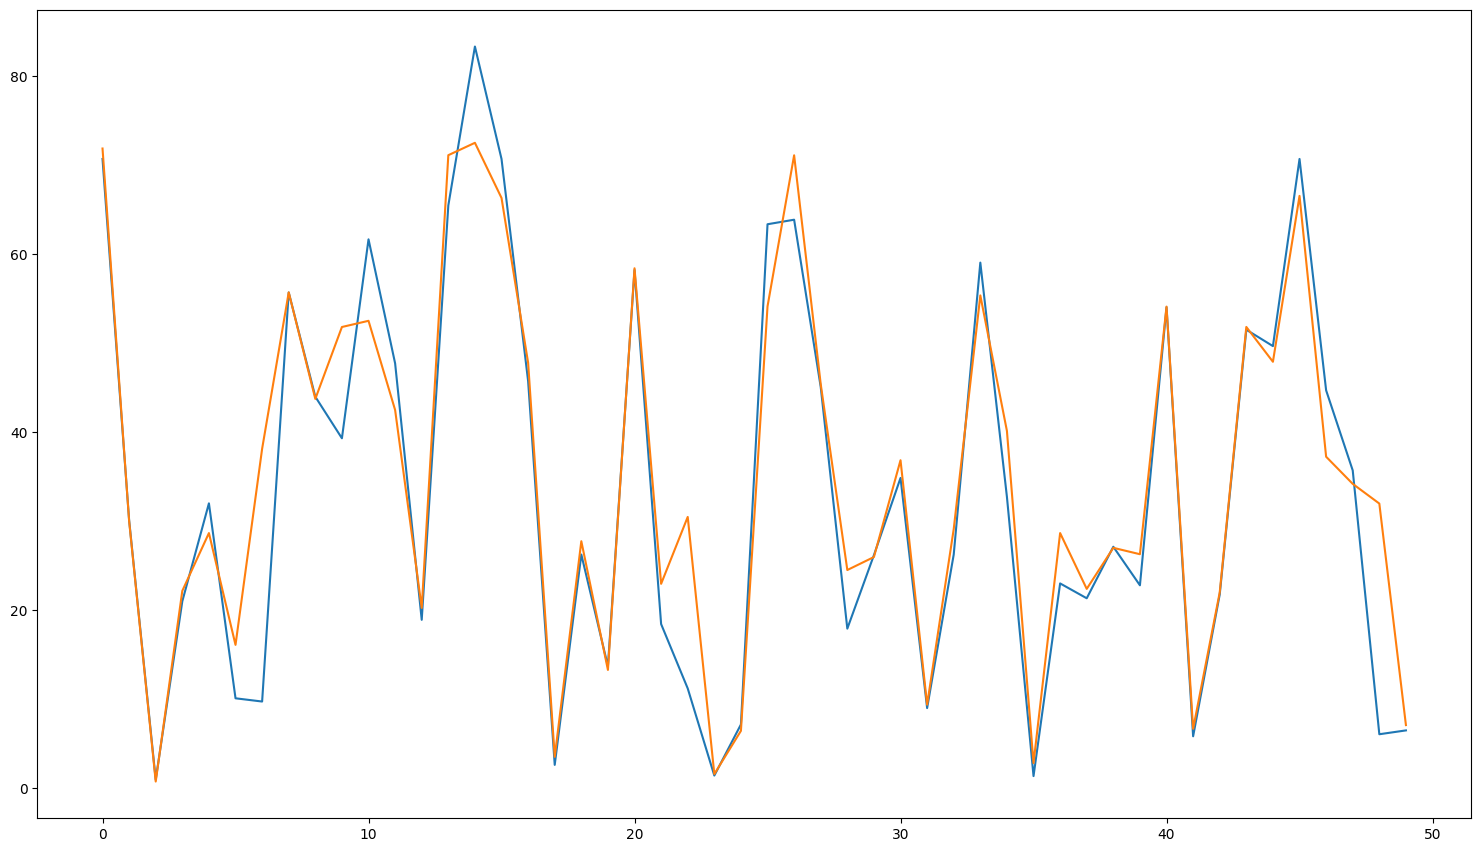

In [70]:
plt.plot(y_test[:50])
plt.plot(outputs[:50].detach())
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

### Load and evaluate the model

In [71]:
from utils import get_data_pred

model.load_state_dict(torch.load("lstm-adjusted-corrected-gt0-500"))
out = get_data_pred('ACAvNTuEuFWcmwms', model, adjust=True, crop='corn')
out

(tensor([[117.9489],
         [139.7947],
         [130.6597],
         [126.9884],
         [148.9546],
         [124.4288],
         [163.7454],
         [176.2565],
         [133.5935],
         [167.6784],
         [163.6089],
         [173.9916],
         [156.3135],
         [158.9479],
         [167.3995],
         [158.9107],
         [157.4998]]),
 2006,
 2022)

In [72]:
from torchmetrics import R2Score
r2score = R2Score()
outputs = model(weather_test)
r2score(outputs.reshape(-1), y_test)

tensor(0.9153, grad_fn=<SqueezeBackward0>)

### Plot the loss

In [36]:
res = pd.DataFrame(data=np.asarray([train_losses, test_losses])).transpose()
res.columns = ['Train loss','Test loss']

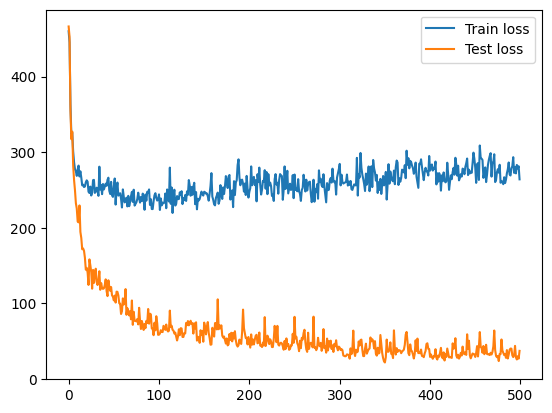

In [37]:
import matplotlib.pyplot as plt
res.plot()
plt.savefig('lstm-adjusted-500-gt0-losses.png')

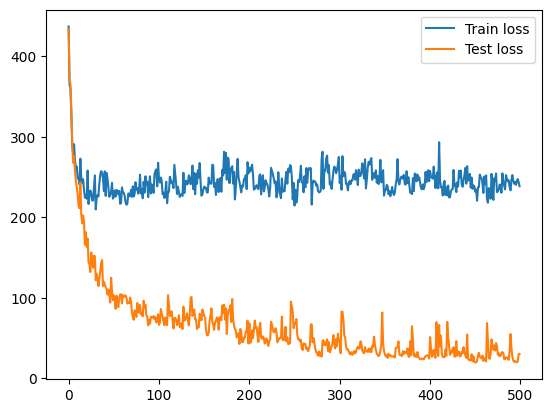

In [19]:
#

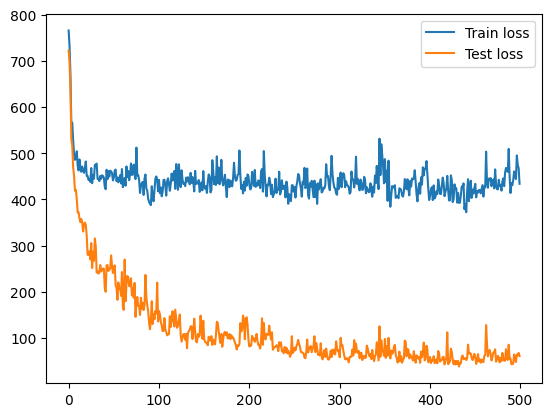

In [17]:
# training on adjusted data including values < 5

<Axes: >

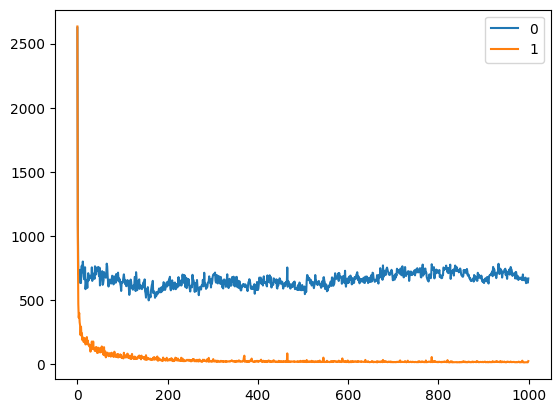

In [72]:
# res.plot() # training without adjustments 

In [38]:
from os import listdir
from os.path import isfile, join
mypath = "../data/weather/prediction_targets_daily/"
filenames = [f[:16] for f in listdir(mypath) if isfile(join(mypath, f))]

In [39]:
import tqdm
preds = []
for filename in tqdm.tqdm(filenames):
    pred, first_year, last_year = get_data_pred(filename, model, adjust=True, crop='corn')
    years = [x for x in range(first_year, last_year + 1)]
    ret = []
    for i in range(len(years)):
        ret.append([years[i], pred[i].item()])
    preds.append(ret)

100%|████████████████████████████████████████████████████████████████████████████████| 198/198 [02:28<00:00,  1.34it/s]


In [40]:
preds

[[[2006, 117.94892883300781],
  [2007, 139.79473876953125],
  [2008, 130.65966796875],
  [2009, 126.98844146728516],
  [2010, 148.9546356201172],
  [2011, 124.42876434326172],
  [2012, 163.74539184570312],
  [2013, 176.25653076171875],
  [2014, 133.59352111816406],
  [2015, 167.67843627929688],
  [2016, 163.60885620117188],
  [2017, 173.9916229248047],
  [2018, 156.31353759765625],
  [2019, 158.94786071777344],
  [2020, 167.3994903564453],
  [2021, 158.9106903076172],
  [2022, 157.49981689453125]],
 [[1973, 84.22523498535156],
  [1974, 110.52589416503906],
  [1975, 65.95414733886719],
  [1976, 97.72647094726562],
  [1977, 122.8284683227539],
  [1978, 111.01228332519531],
  [1979, 93.04835510253906],
  [1980, 103.95033264160156],
  [1981, 126.67039489746094],
  [1982, 99.38475036621094],
  [1983, 91.393798828125],
  [1984, 97.77845764160156],
  [1985, 120.57463073730469],
  [1986, 123.18555450439453],
  [1987, 108.17537689208984],
  [1988, 113.7830810546875],
  [1989, 102.55908203125],


In [41]:
data = []
for i in range(len(filenames)):
    for p in preds[i]:
        data.append([filenames[i], str(p[0]), "Corn, Grain", p[1]])

In [42]:
pd.DataFrame(data, columns=["Target location","Year","Crop","Predicted yield (BUacre)"]).to_csv('corn_predicts.csv', index=False)

In [43]:
pd.DataFrame(data, columns=["Target location","Year","Crop","Predicted yield (BUacre)"])

,Target location,Year,Crop,Predicted yield (BUacre)
0,ACAvNTuEuFWcmwms,2006,"Corn, Grain",117.948929
1,ACAvNTuEuFWcmwms,2007,"Corn, Grain",139.794739
2,ACAvNTuEuFWcmwms,2008,"Corn, Grain",130.659668
3,ACAvNTuEuFWcmwms,2009,"Corn, Grain",126.988441
4,ACAvNTuEuFWcmwms,2010,"Corn, Grain",148.954636
...,...,...,...,...
5070,zuWktVTnYICcsVFr,2018,"Corn, Grain",186.384186
5071,zuWktVTnYICcsVFr,2019,"Corn, Grain",174.585938
5072,zuWktVTnYICcsVFr,2020,"Corn, Grain",189.446808
5073,zuWktVTnYICcsVFr,2021,"Corn, Grain",192.905319
